# Analogue Functions

This notebook contains the functions to work with the CMIP6 Pre-Industrial Trials.

In [51]:
#temperature trends function
#load in pre-industrial data and select temperature and geopotential heights specified
# calculate the TXx temperature trend at each gridpoint in the Northern Hemisphere 
#(defined 30-60N with 5 degrees of buffer for box centering =)

def TXx_trend(start_year, keep_trends = True, plot = True):
    #import libraries
    import xarray as xr
    import numpy as np
    import matplotlib.pyplot as plt
    import scipy.stats as stats
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    
    filepath = '/scratch/rwhite/shared/CESM_PI/dailySSTs/'
    temps_filename = 'f.e21.F1850.f09_f09_mg17.DAILYSSTIC_CMIP6-piControl.001.cam.h1.TREFHT.*.nc'
    gph_filename = 'f.e21.F1850.f09_f09_mg17.DAILYSSTIC_CMIP6-piControl.001.cam.h1.Z500.*.nc'
    
    start = str(start_year)
    end = str(start_year + 70)
    year_range = slice(start, end)
    
    with xr.open_mfdataset(filepath+temps_filename) as temp_data:
        date_indices = np.where(temp_data.time.dt.season == 'JJA')[0] #find where dates are in summer
        #allow 5 degrees on top and bottom to account for the boxes centered at either 30 or 60 N
        #select summer days
        temperature_data = temp_data.sel(lat = slice(25,65), time = temp_data.time[date_indices]).TREFHT #select midlatitudes
        temp_data_period = temperature_data.sel(time = year_range)
        
    #calculate temperature trends at each gridpoint
    latitudes = temp_data_period.lat
    longitudes = temp_data_period.lon

    #### Make Temperature Trends Array
    trends = np.zeros((len(longitudes), len(latitudes)))
    TXx_NH = temp_data_period.groupby('time.year').max().values
    counter = 0
    for i,lon in enumerate(longitudes):
        for j,lat in enumerate(latitudes):
            temp_field = TXx_NH[:,j,i] #select temperature field at lon,lat
            TXx = temp_field
            time = temp_data_period.groupby('time.year').mean().year #make time array
            trend = stats.linregress(time, TXx).slope
            trends[i,j] = trend

            #check if array is actually working
            if counter % 1000 == 0:
                print(counter)
            counter +=1
    #make Data Array
    trends_map = xr.DataArray(trends.T, coords = {"lat": latitudes,"lon":longitudes}, dims = ['lat', 'lon'])
    
    if keep_trends == True:
        trends_map.to_netcdf('/scratch/rwhite/jrobs12/analogue_data/cmip6'+start+'_trends1.nc')
    
    if plot == True:
        #plot trends
        plt.figure(figsize = (20,5))
        ax = plt.subplot(projection = ccrs.PlateCarree())
        plt.contourf(trends_map.lon, trends_map.lat, trends_map.values, extend = 'both', 
                     transform = ccrs.PlateCarree(), cmap = 'RdYlBu_r', vmin = -0.02, vmax = 0.02)
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=1.5)
        plt.colorbar(orientation = 'horizontal', shrink = 0.5, label = 'Temperature Trend (degC/year)')
        plt.title("Temperature Trends Over Midlatitues for" + start)
    
    return trends_map

In [168]:
#trends over box function

def TXx_trend_boxes(start_year,trends_map, plot = True):
    #import libraries
    import xarray as xr
    import numpy as np
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    
    #get mask
    mask_all = xr.open_dataset('/scratch/rwhite/jrobs12/analogue_data/cmip6_trials/pre_industrial_mask.nc').LANDFRAC
    
    ## make boxes to calculate temperature trend averages
    lat_range = trends_map.sel(lat = slice(30,60)).lat
    lon_range = trends_map.lon

    trend_average = np.zeros((len(lon_range), len(lat_range)))
    counter = 0
    #go through every gridpoint and centre a box at that gridpoint
    for i,lon in enumerate(lon_range):
        for j,lat in enumerate(lat_range):
            lat_top, lat_bottom = lat + 5, lat - 5 #want 5 degrees on either side of the centre gridbox
            lon_top, lon_bottom = lon + 10, lon - 10 #want 10 degrees on either side of the centre gridbox
            trend_box = trends_map.sel(lon = slice(lon_bottom, lon_top), lat = slice(lat_bottom, lat_top))
            mask = mask_all.sel(lon = slice(lon_bottom, lon_top), lat = slice(lat_bottom, lat_top))
            #select trend box
            if lon < 20:
                lon_west = 360 + (lon - 10) #farthest part of the box
                lon_east = lon + 10
                lons_west = trends_map.sel(lon = slice(lon_west,360)).lon.values
                lons_east = trends_map.sel(lon = slice(0,lon_east)).lon.values
                lons = np.concatenate((lons_east,lons_west))
                trend_box = trends_map.sel(lon = lons, lat = slice(lat_bottom, lat_top))
                mask = mask_all.sel(lon = lons, lat = slice(lat_bottom, lat_top))
            if lon > 340:
                lon_west = lon - 10
                lon_east = (lon+10) - 360
                lons_west = trends_map.sel(lon = slice(lon_west,360)).lon.values
                lons_east = trends_map.sel(lon = slice(0,lon_east)).lon.values
                lons = np.concatenate([lons_west, lons_east])
                trend_box = trends_map.sel(lon = lons, lat = slice(lat_bottom, lat_top))
                mask = mask_all.sel(lon = lons, lat = slice(lat_bottom, lat_top))
            #weight the trends in the box by latitude
            lats4weights = trend_box.lat
            weights1 = np.cos(np.deg2rad(lats4weights))
            weights = weights1/np.mean(weights1)

            trendbox_weighted = trend_box.groupby('lat')*weights
            trendbox_masked = trendbox_weighted*mask
            #take mean over the box
            trendbox_mean = trendbox_masked.mean(dim = ['lat', 'lon'])
            trend_average[i,j] = trendbox_mean

            if counter % 1000 == 0:
                print(counter)
            counter += 1
    #make the trends an xarray array
    trendsmean_map = xr.DataArray(trend_average.T, coords = {"lat": lat_range,"lon":lon_range}, dims = ['lat', 'lon'])
    trendsmean_map_land = trendsmean_map*mask_all

    #find the area of maximum trend
    trendsmean_max = (trendsmean_map_land).max() #find the area of highest thermodynamical trend
    max_where = np.where(trendsmean_map == trendsmean_max)
    
    max_lat = trendsmean_map.lat[max_where[0]]
    max_lon = trendsmean_map.lon[max_where[1]]
    print(f'The gridbox with the highest thermodynamical trend box is at {round(float(max_lon),2)}E and {round(float(max_lat),2)}N')
    print(f'The highest thermodynamical trend over land is: {trendsmean_max.values}degC/year')
    
    if plot == True:
        #plot trends
        plt.figure(figsize = (20,5))
        ax = plt.subplot(projection = ccrs.PlateCarree())
        plt.contourf(trendsmean_map_land.lon, trendsmean_map_land.lat, trendsmean_map_land.values, extend = 'both', 
                     transform = ccrs.PlateCarree(), cmap = 'RdYlBu_r', vmin = -0.015, vmax = 0.015)
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=1.5)
        plt.colorbar(orientation = 'horizontal', shrink = 0.5, label = 'Temperature Trend (degC/year)')
        plt.scatter(max_lon, max_lat, marker = "*", color = 'w',transform = ccrs.PlateCarree() )
        plt.title("20x10 degree average Over NH Midlatitues for " + str(start_year))
    return max_lon, max_lat

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
The gridbox with the highest thermodynamical trend box is at 51.25E and 57.96N
The highest thermodynamical trend over land is: 0.02034428337637492degC/year


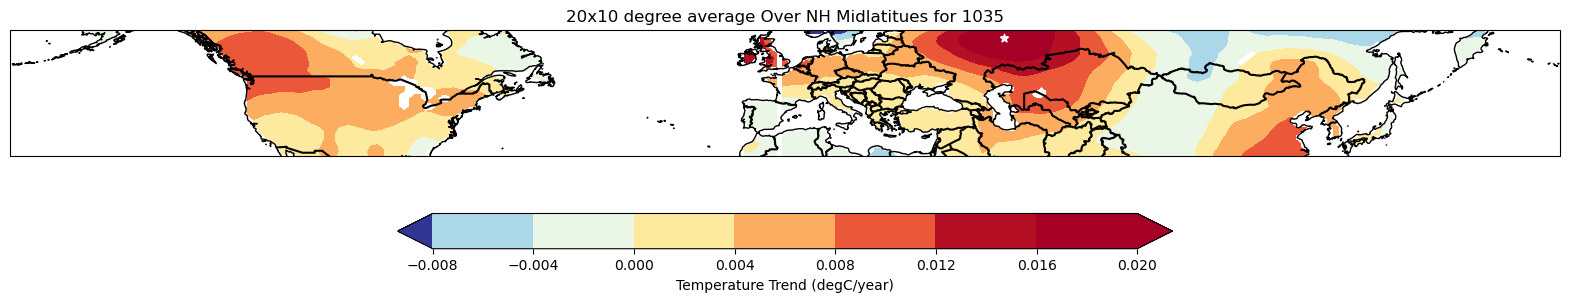

In [170]:
max_lon,max_lat = TXx_trend_boxes(1035,trends)

In [215]:
def find_analogues(max_lon, max_lat, start_year, save_anlgs = False):
    
    #import libraries
    import xarray as xr
    import numpy as np
    import matplotlib.pyplot as plt
    import scipy.stats as stats
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    
    filepath = '/scratch/rwhite/shared/CESM_PI/dailySSTs/'
    temps_filename = 'f.e21.F1850.f09_f09_mg17.DAILYSSTIC_CMIP6-piControl.001.cam.h1.TREFHT.*.nc'
    gph_filename = 'f.e21.F1850.f09_f09_mg17.DAILYSSTIC_CMIP6-piControl.001.cam.h1.Z500.*.nc'
    
    start = str(start_year)
    end = str(start_year + 70)
    year_range = slice(start, end)
    
    
    with xr.open_mfdataset(filepath+temps_filename) as temp_data:
        date_indices = np.where(temp_data.time.dt.season == 'JJA')[0] #find where dates are in summer
        #allow 5 degrees on top and bottom to account for the boxes centered at either 30 or 60 N
        #select summer days
        temperature_data = temp_data.sel(lat = slice(25,65), time = temp_data.time[date_indices]).TREFHT #select midlatitudes
        temp_data_period = temperature_data.sel(time = year_range)
    
    with xr.open_mfdataset(filepath + gph_filename) as geop_data:
        #select midlatitudes + buffer region and select summer days
        gph_data = geop_data.sel(lat = slice(15,75),time = geop_data.time[date_indices]) #add 15 degrees of buffer
        gph_data_period = gph_data.sel(time = year_range) #select days in 70 year period
        gph_data500 = gph_data_period.sel(lev = 500, method = 'nearest').drop_dims('ilev').Z500
        
    ##find geopotential height anomalies
    gph_clim = gph_data500.mean(dim = 'time')
    gph_anomaly = gph_data500 - gph_clim
    
    #make a new (non dask) array 
    gph_anomaly = xr.DataArray(gph_anomaly.values, coords = {"time":gph_anomaly.time,"lat": gph_anomaly.lat,
                                               "lon":gph_anomaly.lon}, dims = ['time','lat', 'lon'])
    temperatures = xr.DataArray(temp_data_period.values, coords = {"time":temp_data_period.time,"lat": temp_data_period.lat,
                                               "lon":temp_data_period.lon}, dims = ['time','lat', 'lon'])
    
    #set up for analogues
    days = gph_anomaly.time[0]
    loop_number = 1
    
    max_lon = round(float(max_lon.lon.values),2)
    max_lat = round(float(max_lat.lat.values),2)
    
    circulation_lon_top, circulation_lon_bottom = max_lon + 25, max_lon - 25
    circulation_lat_top, circulation_lat_bottom =  max_lat + 15, max_lat - 15
    
    
    anomaly = gph_anomaly.sel(lat = slice(circulation_lat_bottom, circulation_lat_top),
                              lon = slice(circulation_lon_bottom, circulation_lon_top)) 
    
    if max_lon < 50:
        lon_west = 360 + (lon - 25) #farthest part of the box
        lon_east = lon + 25
        lons_west = trends_map.sel(lon = slice(lon_west,360)).lon.values
        lons_east = trends_map.sel(lon = slice(0,lon_east)).lon.values
        lons = np.concatenate((lons_east,lons_west))
        anomaly = gph_anomaly.sel(lon = lons, lat = slice(lat_bottom, lat_top))
        
    if max_lon > 310:
        lon_west = lon - 25
        lon_east = (lon+25) - 360
        lons_west = trends_map.sel(lon = slice(lon_west,360)).lon.values
        lons_east = trends_map.sel(lon = slice(0,lon_east)).lon.values
        lons = np.concatenate([lons_west, lons_east])
        anomaly = gph_anomaly.sel(lon = lons, lat = slice(lat_bottom, lat_top))
    
    test_days = gph_anomaly.time.values
    ################################################################
    ### Find Analogues for the region
    for day in test_days: #for every day in the 70 year period
        date_sel = day
        max_date = anomaly.sel(time = date_sel)

        ##calculate ACC
        num = (max_date*anomaly).sum(dim=['lat', 'lon'], skipna = True)
        denom = (anomaly**2).sum(dim=['lat','lon'],skipna = True)*(max_date**2).sum(dim=['lat','lon'], skipna = True)
        corr = num/denom**(1/2)
        corr_sort = corr.sortby(corr, ascending = False)

        # take time difference between each adjacent point in sorted data
        time_diffs = corr_sort.time.values.astype('datetime64[D]') - max_date.time.values.astype('datetime64[D]')
        # find indices where time difference is > 14 days
        time_diffs_inds_sel = np.where(np.abs(time_diffs) > np.timedelta64(1,'D'))[0]

        #take analogues
        index = 0 

        #find first analogue
        anlg_date1 = corr_sort.time.values[time_diffs_inds_sel[index]]
        index = 1 #update index

        #find 2nd analogue
        anlg_date2 = corr_sort.time.values[time_diffs_inds_sel[index]]
        index = 2 #update index (lloking at 3rd element in the array)

        #check that anlg_date1 and anlg_date2 are 6 days apart
        time_diff12 = (np.abs(anlg_date1 - anlg_date2)).days

        check = time_diff12> np.timedelta64(6,'D') #check
        #summing a boolean results in 1 for true and 0 for false
        #if the sum is false then we enter the loop
        if check.sum() < 1:
            anlg_date2 = corr_sort.time.values[time_diffs_inds_sel[index]]
            anlg_diff12 = (np.abs(anlg_date1 - anlg_date2)).days
            diff = anlg_diff12
            check = diff > np.timedelta64(6,'D')
            index = index + 1
            while check.sum() < 1:
                anlg_date2 = corr_sort.time.values[time_diffs_inds_sel[index]]
                anlg_diff12 = (np.abs(anlg_date1 - anlg_date2)).days
                diff = anlg_diff12
                check = diff > np.timedelta64(6,'D')
                index = index + 1
        else:
            index = 2

        #get 3rd analogue
        anlg_date3 = corr_sort.time.values[time_diffs_inds_sel[index]]
        index += 1 #update index
        #take differences
        anlg_diff13 = (np.abs(anlg_date1 - anlg_date3)).days
        anlg_diff23 = (np.abs(anlg_date2 - anlg_date3)).days
        anlg_diffs = [anlg_diff13, anlg_diff23]
        check = anlg_diffs > np.timedelta64(6,'D') #check

        #do it all again for the next analogue
        if check.sum() < 2:
            anlg_date3 = corr_sort.time.values[time_diffs_inds_sel[index]]
            index += 1
            anlg_diff13 = (np.abs(anlg_date1 - anlg_date3)).days
            anlg_diff23 = (np.abs(anlg_date2 - anlg_date3)).days
            diff = [anlg_diff13, anlg_diff23]
            check = diff > np.timedelta64(6,'D')
            while check.sum() < 2:
                anlg_date3 = corr_sort.time.values[time_diffs_inds_sel[index]]
                index += 1
                anlg_diff13 = (np.abs(anlg_date1 - anlg_date3)).days
                anlg_diff23 = (np.abs(anlg_date2 - anlg_date3)).days
                diff = [anlg_diff13, anlg_diff23]
                check = diff > np.timedelta64(6,'D')

        #anlg_all = xr.concat([anomaly.sel(time = anlg_date1), anomaly.sel(time=anlg_date2), anomaly.sel(time=anlg_date3)], dim='N')
        #anlg_temps = temperatures.sel(time = anlg_all.time)
        anlg_temps1 = temperatures.sel(time = anlg_date1).assign_coords(time=date_sel)
        anlg_temps2 = temperatures.sel(time = anlg_date2).assign_coords(time=date_sel)
        anlg_temps3 = temperatures.sel(time = anlg_date3).assign_coords(time=date_sel)
        # take mean over new dimension, N
        #anlg_temps_avg = anlg_temps.mean(dim='N').assign_coords(time=date_sel)

        # if this is the first time point, create new analogue temp field
        #   that will be continually added to
        if loop_number == 1:
            #anlg_mix = anlg_temps_avg
            anlg_mix1 = anlg_temps1
            anlg_mix2 = anlg_temps2
            anlg_mix3 = anlg_temps3

        else:
            # if this is not first time point,
            #    add to new analogues to ongoing temp field dataArray
            #anlg_mix = xr.concat([anlg_mix, anlg_temps_avg], dim='time')
            anlg_mix1 = xr.concat([anlg_mix1, anlg_temps1], dim='time')
            anlg_mix2 = xr.concat([anlg_mix2, anlg_temps2], dim='time')
            anlg_mix3 = xr.concat([anlg_mix3, anlg_temps3], dim='time')
        loop_number += 1
        if loop_number % 500 == 0:
            print(loop_number)
    ##calculate TXx for the analogues
    anlg_ts1 = anlg_mix1
    anlg_ts2 = anlg_mix2
    anlg_ts3 = anlg_mix3

    #first analogue set
    anlg_TXx1 = anlg_ts1.sel(lon = slice(max_lon-10, max_lon + 10), lat = slice(max_lat-5,max_lat+5)).groupby("time.year").max()
    #analogue weights
    anlg_w = np.cos(np.deg2rad(anlg_TXx1.lat))
    anlg_weights = anlg_w/np.mean(anlg_w)

    anlg_TXx1_w = anlg_TXx1.mean(dim = 'lon').groupby('lat')*anlg_weights
    anlg_TXx1_weighted = anlg_TXx1_w.mean(dim = 'lat')

    #second analogue set
    anlg_TXx2 = anlg_ts2.sel(lon = slice(max_lon-10, max_lon + 10), lat = slice(max_lat-5,max_lat+5)).groupby("time.year").max()
    anlg_TXx2_w = anlg_TXx2.mean(dim = 'lon').groupby('lat')*anlg_weights
    anlg_TXx2_weighted = anlg_TXx2_w.mean(dim = 'lat')

    #third analogue set
    anlg_TXx3 = anlg_ts3.sel(lon = slice(max_lon-10, max_lon + 10), lat = slice(max_lat-5,max_lat+5)).groupby("time.year").max()
    anlg_TXx3_w = anlg_TXx3.mean(dim = 'lon').groupby('lat')*anlg_weights
    anlg_TXx3_weighted = anlg_TXx3_w.mean(dim = 'lat')


    #take average of all three sets of analogues for each year
    anlg_TXx = (anlg_TXx1_weighted + anlg_TXx2_weighted + anlg_TXx3_weighted)/3    
    
    ## calculate trend at each gridpoint
    anlg_lat, anlg_lon = anlg_TXx1.lat, anlg_TXx1.lon
    time = anlg_TXx1.year
    TXx1_map = np.zeros((len(anlg_lon), len(anlg_lat)))
    TXx2_map = np.zeros((len(anlg_lon), len(anlg_lat)))
    TXx3_map = np.zeros((len(anlg_lon), len(anlg_lat)))

    counter = 0 #counter b/c i'm impatient
    for i,lon in enumerate(anlg_lon):
        for j,lat in enumerate(anlg_lat):
            #select the gridpoint
            anlg1 = anlg_TXx1.sel(lat = lat, lon = lon)
            anlg2 = anlg_TXx2.sel(lat = lat, lon = lon)
            anlg3 = anlg_TXx3.sel(lat = lat, lon = lon)

            #find the trend at each gridpoint
            trend1 = stats.linregress(time,anlg1)
            trend2 = stats.linregress(time,anlg2)
            trend3 = stats.linregress(time,anlg3)

            #add trends into the map arrays
            TXx1_map[i,j] = trend1.slope
            TXx2_map[i,j] = trend2.slope
            TXx3_map[i,j] = trend3.slope

            if counter % 100 == 0:
                print(counter)
            counter += 1

    #make map arrays xarray DataArrays
    anlg_map1 = xr.DataArray(TXx1_map.T, coords = {"lat": anlg_TXx1.lat,"lon": anlg_TXx1.lon}, dims = ['lat', 'lon'])
    anlg_map2 = xr.DataArray(TXx2_map.T, coords = {"lat": anlg_TXx1.lat,"lon": anlg_TXx1.lon}, dims = ['lat', 'lon'])
    anlg_map3 = xr.DataArray(TXx3_map.T, coords = {"lat": anlg_TXx1.lat,"lon": anlg_TXx1.lon}, dims = ['lat', 'lon'])
    
    ##average anlg maps together
    anlg_mean = (anlg_map1 + anlg_map2 + anlg_map3)/3
    if save_anlgs == True:
        anlg_mean.to_netcdf('/scratch/rwhite/jrobs12/analogue_data/cmip6_trials/anlgs'+str(start_year)+'_means.nc')
    
    ##plot all trends together
    fig = plt.figure(figsize = (10,8))
    ax1 = plt.subplot(2,2,1, projection = 
                            ccrs.Orthographic(central_longitude=max_lon, central_latitude=max_lat))
    ax1.contourf(anlg_mean.lon, anlg_mean.lat, anlg_mean.values, cmap = "RdYlBu_r")
    ax1.coastlines()
    ax1.add_feature(cfeature.BORDERS, linewidth=1.5)
    ax1.scatter(max_lon, max_lat, marker = "*", color = 'k')
    ax1.set_title("Average Trend Over 3 Analogues")

    #plot closest analogue trends
    ax2 = plt.subplot(2,2,2, projection = 
                            ccrs.Orthographic(central_longitude=max_lon, central_latitude=max_lat))
    ax2.contourf(anlg_mean.lon, anlg_mean.lat, anlg_map1.values, cmap = "RdYlBu_r")
    ax2.coastlines()
    ax2.add_feature(cfeature.BORDERS, linewidth=1.5)
    ax2.scatter(max_lon, max_lat, marker = "*", color = 'k')
    ax2.set_title("1st closest analogue")

    #plot 2nd closest analogue
    ax3 = plt.subplot(2,2,3, projection = 
                            ccrs.Orthographic(central_longitude=max_lon, central_latitude=max_lat))
    ax3.contourf(anlg_mean.lon, anlg_mean.lat, anlg_map2.values, cmap = "RdYlBu_r")
    ax3.coastlines()
    ax3.add_feature(cfeature.BORDERS, linewidth=1.5)
    ax3.scatter(max_lon, max_lat, marker = "*", color = 'k')
    ax3.set_title("2nd closest analogue")

    #plot 3rd closest analogue
    ax4 = plt.subplot(2,2,4, projection = 
                            ccrs.Orthographic(central_longitude=max_lon, central_latitude=max_lat))
    f = ax4.contourf(anlg_mean.lon, anlg_mean.lat, anlg_map3.values, cmap = "RdYlBu_r", extend = 'both')
    ax4.coastlines()
    ax4.add_feature(cfeature.BORDERS, linewidth=1.5)
    ax4.scatter(max_lon, max_lat, marker = "*", color = 'k')
    ax4.set_title("3rd closest analogue")

    fig.colorbar(f, ax = [ax1,ax2,ax3,ax4], shrink = 0.5, label = 'Temperature Trend (degC/year)', location = 'bottom')
    
    #find average trend over box area
    anlg_mean_trend = anlg_mean.mean()
    print(f' The Average Dynamical Trend over the box with the highest thermodynamical trend is: {anlg_mean_trend.values} degC/year')

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
0
100
 The Average Dynamical Trend over the box with the highest thermodynamical trend is: 0.0019407345734476064 degC/year


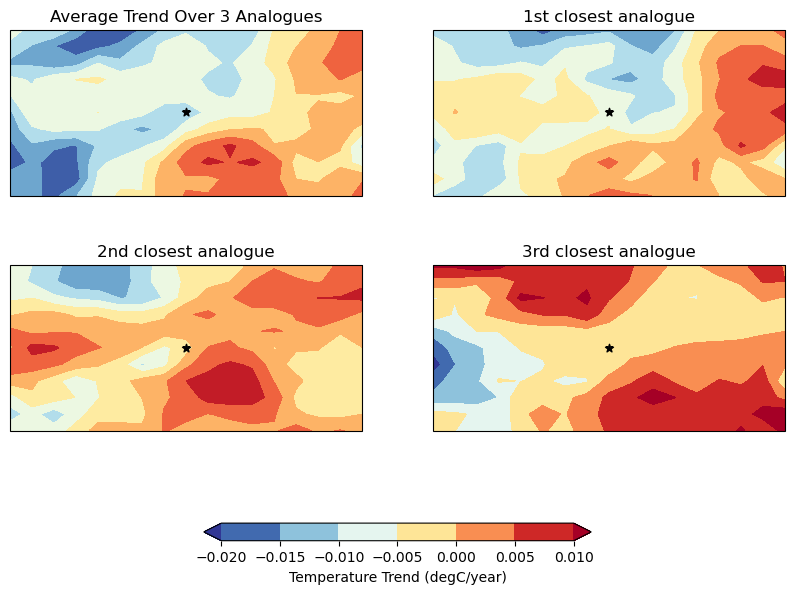

In [216]:
anlgs = find_analogues(max_lon,max_lat,1035)